# Global indicator project
## Create sausage buffer 

This notebook creates sausage buffer to determine local walkable neighborhood (1600m sample points + 50m walkable netowrk buffer)



In [68]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

from descartes import PolygonPatch
from shapely.geometry import shape,Point, LineString, Polygon


ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

### Set up project config

In [11]:
place = 'phoenix' 

region = 'Arizona, USA' # study region name

suffix = '_201905' # output data time

buffer_dist = 1e4 #study region buffer 10km

point_dist = 30 #sample point interval distance

network_type='walk'

OSM_folder = '../data/OSM'

G_filename = 'Phoenix, Arizona, USA_walk_201905.graphml'

point_filepath = '../data/OSM/phoenix_sample_points_201905/phoenix_sample_points_201905.shp'

## Load pedestrain street network and sample points from local folder

In [12]:
G = ox.load_graphml(filename=G_filename, folder=OSM_folder)

In [13]:
# save sample point shapefile
sample_points = gpd.GeoDataFrame.from_file(point_filepath)

In [14]:
sample_points.geometry.head()

0    POINT (399320.4111184602 3704054.876976978)
1    POINT (399269.4426971063 3704055.375501406)
2    POINT (399320.4111184602 3704054.876976978)
3    POINT (399337.8713994289 3704054.705951796)
4    POINT (399320.4111184602 3704054.876976978)
Name: geometry, dtype: object

In [109]:
# load sample point locations over which we'll iterate
point_locations = [(399320.4111184602, 3704054.876976978),(399269.4426971063, 3704055.375501406), (399320.4111184602, 3704054.876976978)]

## Create sausage buffer

In [180]:
# create sausage buffer
def create_sausage_buffer(G, orig_point, buffer=50, length = 1600, intersection_tolerance = 15):
    # locate closest node on network to 
    orig_node = ox.get_nearest_node(G, orig_point, return_dist=True)
    subgraph = nx.ego_graph(G, orig_node[0], radius=length, distance='length')
    # We project the subgraph to UTM so we can use metres as a unit when buffering
    subgraph_proj = ox.project_graph(subgraph)
    # create buffer
    subgraph_gdf = ox.graph_to_gdfs(subgraph_proj, nodes=False, edges=True, fill_edge_geometry=True)
    buffer = subgraph_gdf.geometry.buffer(buffer)
    buffer_uu = buffer.geometry.unary_union
    return([subgraph_gdf, buffer_uu]) #output is list of a sample point graph (1600m), and buffer polygon

In [181]:
sausagebuffers = []

for point in point_locations:
    task = 'Buffer network'
    start = time.time()
    sausagebuffers.append(create_sausage_buffer(G, point))
    print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 

Completed task "Buffer network" in 0.40 seconds
Completed task "Buffer network" in 0.61 seconds
Completed task "Buffer network" in 0.35 seconds


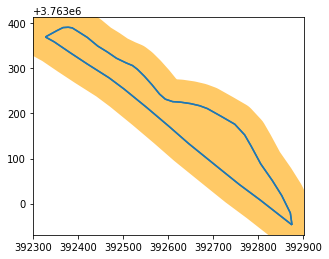

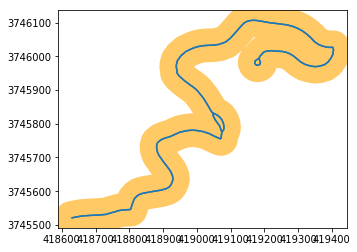

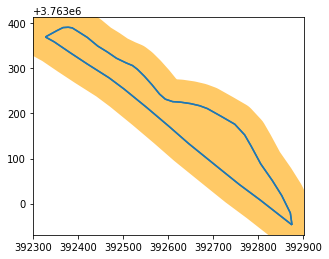

In [186]:
for x in [0,1,2]:
    ax = sausagebuffers[x][0].plot()

    patch = PolygonPatch(sausagebuffers[x][1], fc='orange', ec='none', alpha=0.6)
    ax.add_patch(patch)
    plt.show()

##### In this case, the first and third sample point result in the same nearest nodes and thus same local neighborhood. How we filter out these sample point within the same buffer (local neighborhood)?

## Get sample point neighborhood stats

In [166]:
# Local neighbourhood analysis
def analyse_local_nh(G, orig_point, buffer=50, length = 1600, intersection_tolerance = 15):
    # locate closest node on network to 
    orig_node = ox.get_nearest_node(G, orig_point, return_dist=True)
    subgraph = nx.ego_graph(G, orig_node[0], radius=length, distance='length')
    # We project the subgraph to UTM so we can use metres as a unit when buffering
    subgraph_proj = ox.project_graph(subgraph)
    # create buffer
    geo = ox.graph_to_gdfs(subgraph_proj, nodes=False, edges=True, fill_edge_geometry=True)
    geo_buffer = geo.geometry.buffer(buffer)
    buffer_uu = geo_buffer.geometry.unary_union
    
    #get stats
    area_sqm = buffer_uu.area
    area_sqkm = area_sqm*1e-06
    stats = ox.basic_stats(subgraph_proj, area=area_sqm, clean_intersects=True, tolerance=intersection_tolerance,
                circuity_dist='euclidean')
    return({
             'area_sqkm':area_sqkm,
             'stats':stats,
             'origin_node_snap_dist': orig_node[1]})
     

In [111]:
# initialise a list
nh_estimates = []
for point in point_locations:
    start = time.time()
    task = "Calculate local neighbourhood measures for points"
    nh_estimates.append(analyse_local_nh(G, point))
    print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 
  

Completed task "Calculate local neighbourhood measures for points" in 0.99 seconds
Completed task "Calculate local neighbourhood measures for points" in 2.73 seconds
Completed task "Calculate local neighbourhood measures for points" in 0.91 seconds


In [117]:
# area in sqkm
[x['area_sqkm'] for x in nh_estimates]

[0.11919372879016825, 0.18025124515962127, 0.11919372879016825]

In [183]:
## clean intersection density per sqkm
[x['stats']['clean_intersection_count'] for x in nh_estimates]

[2, 6, 2]

issue: there are a lot of sample points associate with the same nearest nodes, then result in the same neighborhood

issue: how to associate the neighborhood stats back to each sample point